In [35]:
import numpy as np
import pandas as pa 
from matplotlib import pyplot as plt 
%matplotlib inline
from qutip import *
import tqdm
from qutip.qip.operations import gates

# Decoherence and Hahn echo 

In NV sensing we often are interested in the nuclear spin enviroment, here a $^{13}$C bath. If we study the 
decoherence of the NV electron spin, we find that the problem can be summarized as: \
    \
    $ H = \omega_s S_z + \sum_i^N \left(\gamma_n B  I_{z,i}  + A_{zz,i} S_z I_{z,i}  + A_{zx,i} S_zI_{x,i} \right) ,$\
\
Because the spins are not interaciting, we can paraell process the evolutions and multiply the measurement outcome probabilities after evolution, this is called cluster expansion.

The sequence goes as the following, with $U(\pi),U(\pi/2)$ for $\pi$ and $\pi/2$ -pulse and $U_i$ for the evolution of $H_i$ for time $\tau$:\
\
$ P(\tau) = \prod_i^N  \rm{expect}\left(\rm{ptrace}\left(U(\pi/2)\, U_i(\tau)\, U(\pi) \, U_i(\tau)\, U(\pi/2)\cdot  \rho_{\rm{init}}  \cdot U^\dagger(\pi/2) \,U_i^\dagger(\tau)\, U^\dagger(\pi)\,  U_i^\dagger(\tau)\, U^\dagger(\pi/2)\right)\right)
$


###  preliminaries


In [36]:
#NV in (0, -1) subspace
sz_e = (sigmaz()-qeye(2))*0.5
sz = tensor(sz_e, qeye(2))

#13C is spin 1/2
iz = tensor(qeye(2), sigmaz()*0.5)
ix = tensor(qeye(2), sigmax()*0.5)
#del(s_z)

#describe the dynamical decoupling with rotations
#pi/2 pulses electron
pi_2_g_e_x = gates.rotation(op=sigmax(), phi=np.pi/2.0, N=2, target=0)
pi_2_g_e_y = gates.rotation(op=sigmay(), phi=np.pi/2.0, N=2, target=0)

#pi pulses electron
pi_g_e_x = gates.rotation(op=sigmax(), phi=np.pi, N=2,target=0)

#
pi_g_e_x_alpha = gates.rotation(op=sigmax(), phi=np.pi*0.1, N=2,target=0)
pi_g_e_mx_alpha = gates.rotation(op=sigmax(), phi=-np.pi*0.1, N=2,target=0)
pi_g_e_y_alpha = gates.rotation(op=sigmay(), phi=np.pi*0.1, N=2,target=0)
pi_g_e_my_alpha = gates.rotation(op=sigmay(), phi=-np.pi*0.1, N=2,target=0)

(array([[1., 0., 2., 1., 1., 1., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 3., 2., 1., 0., 1.]]),
 array([-0.20073436, -0.15067944, -0.10062452, -0.0505696 , -0.00051468,
         0.04954024,  0.09959516,  0.14965008,  0.199705  ,  0.24975992,
         0.29981485]),
 <a list of 2 BarContainer objects>)

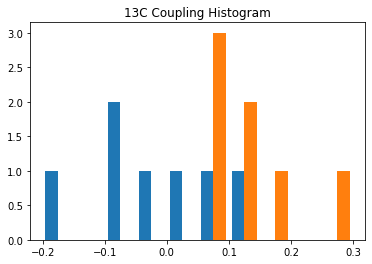

In [53]:
class NV:
    def __init__(self, c13_zz,c13_zx,B):
        self.C13_zz = c13_zz
        self.C13_zx = c13_zx
        self.B = B
        self.init_h()
        
    def init_h(self):
        self.H = []
        gamma_e = 2.8 #MHz/G
        gamma_n = 10.7*1e-4 # MHz/G
        for i,zz in enumerate(self.C13_zz):
            self.H.append(
                iz*gamma_n*B*2*np.pi + 2*np.pi*sz*iz*zz +
                2*np.pi*sz*ix*self.C13_zx[i]
            )        
                
    def evolve_i(self, rho, seq, i):        
        rho1 = rho
        for s in seq:
            if isinstance(s, Qobj):
                rho1 = s*rho1*s.dag()
            elif isinstance(s, float):
                U = (self.H[i]*1j*s).expm()
                rho1 = U*rho1*U.dag()
            elif isinstance(s, dict):
                out = mesolve(rho0=rho1, H=self.H, c_ops=[tensor(sigmaz(),qeye(2))], tlist=np.linspace(0,s['T_c'], 10), 
                          options = Options(nsteps=1e5))
                return out.states[-1]                
        return rho1
    
    def experiment(self, seq, **kwargs):
        Pi = 1
        rho = tensor(fock_dm(2,0), qeye(2)*0.5)
        for i,zz in enumerate(self.C13_zz):
            rho1 = self.evolve_i(rho, seq(**kwargs),i)
            p0 = expect(sigmaz(), rho1.ptrace(0))
            Pi *= p0
        return Pi
    
    def hahn_echo(self,tau):
        seq = [
            pi_2_g_e_y, 
            tau, 
            pi_g_e_x,
            tau,
            pi_2_g_e_y.dag()
            ]
        return seq
    
    
    
#create random bath:
C13_zz_b = np.random.normal(loc = 0, scale =0.15, size=5)#[0.13, 0.13,0.1, 0.04,0.002,0.05, 0.1]
C13_zx_b = np.random.normal(loc=0,scale=0.15, size=5)

#add two known spins to it
C13_zz = np.array([-200.73436071,52.2228743806])*1e-3
C13_zx = np.array([73.365909271,143.61522982])*1e-3
C13_zz = np.append(C13_zz, C13_zz_b)
C13_zx = np.append(C13_zx, C13_zx_b)

mynv = NV(B=50, c13_zx=C13_zz, c13_zz=C13_zx)

plt.title('13C Coupling Histogram')
plt.hist([C13_zz, C13_zx])



### DD run

In [54]:
Phe = []
taus = np.linspace(0,50,200)
for tau in tqdm.tqdm_notebook(taus):
    Phe.append(mynv.experiment(seq=mynv.hahn_echo,tau=tau))

<ipython-input-54-21f8bc21ab1e>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for tau in tqdm.tqdm_notebook(taus):


C:\Users\yy3\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


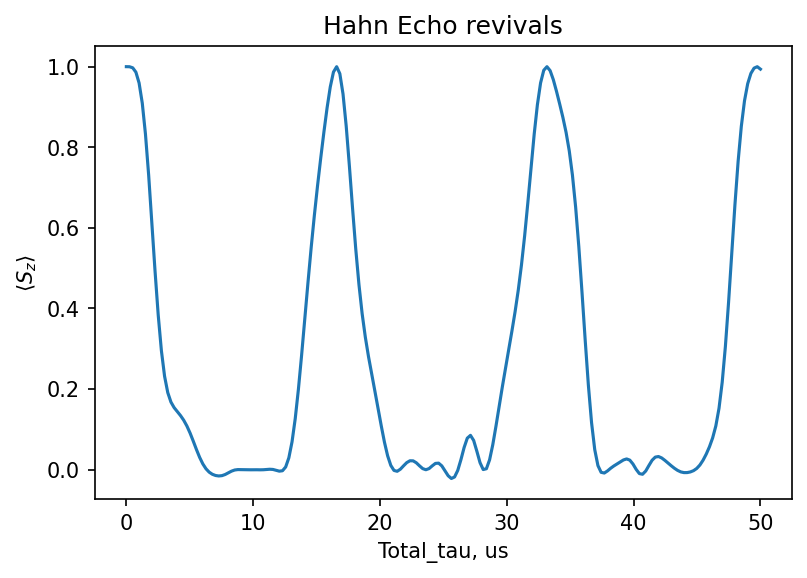

In [55]:
plt.figure(dpi=150)

plt.plot(taus, np.array(Phe))
plt.xlabel('Total_tau, us')
plt.ylabel('$\\langle S_z \\rangle$')
plt.title('Hahn Echo revivals')
plt.savefig('hahn-echo.png')